# **Explain Like I'm Not a Scientist**
### *An exploration of (not so) scientific communication*
| | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|Emily K. Sanders| | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Project 3: NLP|
|DSB-318| | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |May 3, 2024|
---
###### *A report for the 2024 Greater Lafayette Association for Data Science Conference on Activism for a Thriving Society*

## Prior Notebooks Summary

In the previous notebooks, I introduced the project, explained the method, and conducted feature engineering and exploratory data analysis.  I showed that my sample is large (n = 9495), but has severely imbalanced classes.

In this notebook, I will conduct my train test split and model fitting.  For purposes of reproducibility, I have used a random state of [113](https://harrypotter.fandom.com/wiki/Sirius_Black) throughout.

## Modeling

In [2]:
# Imports
import pandas as pd       
import matplotlib.pyplot as plt
import os
import numpy as np
from datetime import datetime, date, time
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
# Read in the dataframe
scrapes = pd.read_csv('../data/input/final-df.csv')

# Define X and y
X = scrapes['text']
y = scrapes['source']

# Collapse categories in y
y = y.map({'askp-comments':0, 'askp':0, 'eli5-comments':1, 'eli5':1})

# Make sure it looks right
print(X.shape, y.shape)
y.value_counts(dropna = False, normalize = True)

(9495,) (9495,)


source
1    0.622433
0    0.377567
Name: proportion, dtype: float64

In the following cells, I fit logistic regressions and naive bayes models, both using CountVectorizer to tokenize and count the words. I used pipelines and gridsearching to test different parameters in search of the best performing model.  I also tested stop words, both the default English stop words in NLTK, and that list plus variations on the subreddit names.

### Instantiations and Test Train Split

In [4]:
# Instantiations
cvec = CountVectorizer(decode_error = 'ignore', strip_accents = 'unicode')
logr = LogisticRegression(random_state = 113, solver = 'saga')
#saga was the only one who could handle all of the penalty types I wanted to try
mnnb = MultinomialNB()

In [5]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size = 0.25, stratify = y, random_state = 113)
print(X_train.shape, y_train.shape)  #(7121,) (7121,)
print(X_test.shape, y_test.shape)  #(2374,) (2374,)

(7121,) (7121,)
(2374,) (2374,)


In [6]:
# Define custom stop words
nltk_stop_words = list(stopwords.words('english'))
my_stop_words = [
  'eli5', 'eli', 'explainlikeim5', 'explainlikeimfive',
  'physics', 'pyhsics' 'physiks', 'fisiks', 'physic', 
  'physik', 'askphysics', 'askphysik', 'askphysiks']
custom_stop_words = nltk_stop_words + my_stop_words
custom_stop_words = custom_stop_words.copy()

### Model 1: Logistic Regression

In [9]:
# Pipeline with cvec and logistic regression

cl_pipe = Pipeline([
  ('cvec', cvec), 
  ('logr', logr)])

cl_pipe_params = {
  'cvec__stop_words': [None, custom_stop_words],
  'cvec__ngram_range': [(1,1)],
  'cvec__max_df': [0.75, 0.95],
  'cvec__min_df': [2, 3],
  'cvec__max_features': [1000],
  'logr__penalty': ['l1', 'l2'],
  'logr__C': [1]
  }

np.random.seed(113)
cl_gs = GridSearchCV(
  cl_pipe, param_grid = cl_pipe_params, cv = 5,
  verbose = 3, n_jobs = -1)

# Gridsearch and fit on the training set
cl_gs.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\emily\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(decode_error='ignore',
                                                        strip_accents='unicode')),
                                       ('logr',
                                        LogisticRegression(random_state=113,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.75, 0.95],
                         'cvec__max_features': [1000], 'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1)],
                         'cvec__stop_words': [None,
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]],
                         'logr__C': [1], 'logr__penalty': ['l1', 'l2']},
             verbose=3)

In [17]:
# See which parameters it picked
cl_gs.best_params_

{'cvec__max_df': 0.75,
 'cvec__max_features': 1000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None,
 'logr__C': 1,
 'logr__penalty': 'l2'}

In [13]:
# Score the model on the training set
cl_gs.score(X_train, y_train)

0.8724898188456678

In [14]:
# Score the model on the testing set
cl_gs.score(X_test, y_test)

0.8513058129738837

This model is already decent, accurately classifying upwards of 80% of the documents.  It doe display some variance though, with a training set several points better than the testing set.

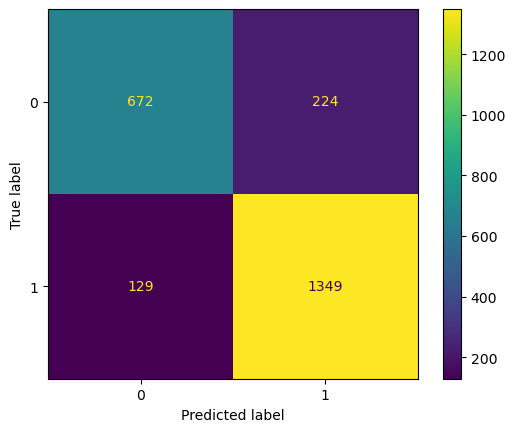

In [16]:
# Get predictions on the testing set
yhat_model = cl_gs.predict(X_test)

# Generate confusion matrix values
cm = confusion_matrix(y_test, yhat_model)

# Save confusion matrix values
tn, fp, fn, tp = cm.ravel()

# Generate confusion matrix
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot();

Note, the labels correpsond to 0 for AskPhysics, and 1 for eli5.

### Model 2: Multinomial Naive Bayes

In [7]:
# Pipeline with cvec and mnnb
cb_pipe = Pipeline([
  ('cvec', cvec), 
  ('mnnb', mnnb)])

cb_pipe_params = {
  'cvec__stop_words': [None, custom_stop_words],
  'cvec__ngram_range': [(1,1)],
  'cvec__max_df': [0.75, 0.95],
  'cvec__min_df': [2, 3],
  'cvec__max_features': [1000],
  'mnnb__alpha': [0.9, 1],
  }

np.random.seed(113)
cb_gs = GridSearchCV(
  cb_pipe, param_grid = cb_pipe_params, cv = 5,
  verbose = 3, n_jobs = -1)

# Gridsearch and fit on the training set
cb_gs.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(decode_error='ignore',
                                                        strip_accents='unicode')),
                                       ('mnnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.75, 0.95],
                         'cvec__max_features': [1000], 'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1)],
                         'cvec__stop_words': [None,
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]],
                         'mnnb__alpha': [0.9, 1]},
             verbose=3)

In [8]:
# See which parameters it picked
cb_gs.best_params_

{'cvec__max_df': 0.75,
 'cvec__max_features': 1000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None,
 'mnnb__alpha': 0.9}

In [14]:
# Score the model on the training set
cb_gs.score(X_train, y_train)

0.8442634461452043

In [15]:
# Score the model on the testing set
cb_gs.score(X_test, y_test)

0.8437236731255265

Although this model performs somewhat worse overall, it provides an improvement in variance reduction.  

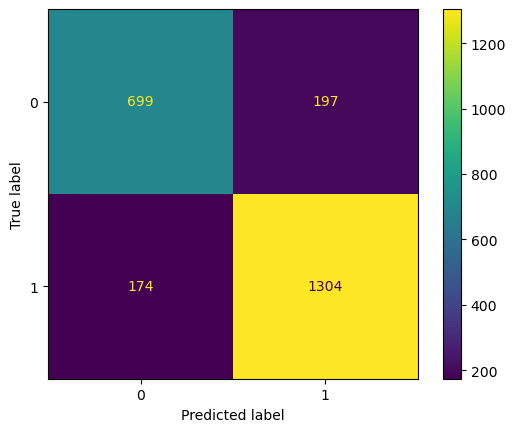

In [16]:
# Get predictions on the testing set
yhat_model = cb_gs.predict(X_test)

# Generate confusion matrix values
cm = confusion_matrix(y_test, yhat_model)

# Save confusion matrix values
tn, fp, fn, tp = cm.ravel()

# Generate confusion matrix
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cb_gs.classes_)
cmd.plot();

In [28]:
cvec_X = pd.DataFrame(data = cvec.fit_transform(X).todense(), columns = cvec.get_feature_names_out())

In [33]:
big = pd.merge(X, y, left_index = True, right_index = True)

In [24]:
scrapes.to_csv('../../cvec_scrapes.csv', index = False)

In [ ]:
for i in list(range(len(big))):
  big.loc[i, 'post_lengths']=big.loc[i,:].sum()

In [ ]:
cvec_X_train['post_lengths'].group

### Commentary

Both models satisfy my metric for accuracy (>80%), and the Bayes model provides excellent variance control (<0.0006).  Model 2 would be an adequate final model, but before adopting it, I gridsearched over some more hyperparameter options to see if it was possible to increase the accuracy even further without increasing variance.

These gridsearches were conducted in a single cell; transparently, this was done for time.  Each search fit nearly 1500 combinations, for a total of nearly 3000, and I expected (correctly) that it would take a long time to run.  Running them in the same cell freed up my attention for a longer stretch of time.  I have used print statements throughout to make the output more readable.

### Gridsearches 3 & 4

In [65]:
# Pipeline with cvec and logistic regression
# Instantiate the pipeline
cl2_pipe = Pipeline([
  ('cvec', cvec), 
  ('logr', logr)])

# Define the parameter grid
cl2_pipe_params = {
  'cvec__stop_words': [None, 'english'],
  'cvec__ngram_range': [(1,1), (1,2)],
  'cvec__max_df': [0.7, 0.75, 0.8],
  'cvec__min_df': [2, 10],
  'cvec__max_features': [100, 1000, 5000],
  'logr__penalty': ['l1', 'l2'],
  'logr__C': [1, 1.3]
  }

# Instantiate the gridsearch with a random seed
np.random.seed(113)
cl2_gs = GridSearchCV(
  cl2_pipe, param_grid = cl2_pipe_params, cv = 5,
  verbose = 1, n_jobs = -1)

# Gridsearch and fit on the training set
cl2_gs.fit(X_train, y_train)

# Print the accuracy scores
print(f'cl2_gs, training: {cl2_gs.score(X_train, y_train)}')
print(f'cl2_gs, testing: {cl2_gs.score(X_test, y_test)}')

######

# Pipeline with cvec and mnnb

# Instantiate the pipeline
cb2_pipe = Pipeline([
  ('cvec', cvec), 
  ('mnnb', mnnb)])

# Define the parameter grid
cb2_pipe_params = {
  'cvec__stop_words': [None, 'english'],
  'cvec__ngram_range': [(1,1), (1,2)],
  'cvec__max_df': [0.7, 0.75, 0.8],
  'cvec__min_df': [2, 10],
  'cvec__max_features': [100, 1000, 5000],
  'mnnb__alpha': [0.85, 0.9, 0.95],
  }

# Instantiate the gridsearch with a random seed
np.random.seed(113)
cb2_gs = GridSearchCV(
  cb2_pipe, param_grid = cb2_pipe_params, cv = 5,
  verbose = 1, n_jobs = -1)

# Gridsearch and fit on the training set
cb2_gs.fit(X_train, y_train)

# Print the accuracy scores
print(f'cb2_gs, training: {cb2_gs.score(X_train, y_train)}')
print(f'cb2_gs, testing: {cb2_gs.score(X_test, y_test)}')

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


C:\Users\emily\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


cl2_gs, training: 0.9105462715910687
cl2_gs, testing: 0.8719460825610783
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
cb2_gs, training: 0.8882179469175677
cb2_gs, testing: 0.8736310025273799


In [68]:
# Print the accuracy scores
print(f'cl2_gs, best cross val score: {cl2_gs.best_score_}')
print(f'cb2_gs, best cross val score: {cb2_gs.best_score_}')

cl2_gs, best cross val score: 0.8640617977528089
cb2_gs, best cross val score: 0.8664509166173862


In [69]:
# See which parameters it picked
print('cl2_gs parameter choices:')
cl2_gs.best_params_

cl2_gs parameter choices:


{'cvec__max_df': 0.7,
 'cvec__max_features': 5000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english',
 'logr__C': 1,
 'logr__penalty': 'l2'}

In [70]:
# See which parameters it picked
print('cb2_gs parameter choices:')
cb2_gs.best_params_

cb2_gs parameter choices:


{'cvec__max_df': 0.7,
 'cvec__max_features': 5000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None,
 'mnnb__alpha': 0.85}

Confusion Matrix for Subreddit Classification
Modeled with Count Vectorizer, Logistic Regression


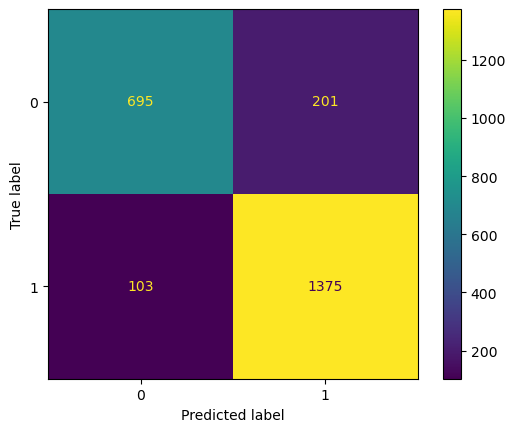

In [77]:
# Get predictions on the testing set
cl2_gs_yhat = cl2_gs.predict(X_test)

# Generate confusion matrix values
cm = confusion_matrix(y_test, cl2_gs_yhat)

# Save confusion matrix values
tn, fp, fn, tp = cm.ravel()

# Generate confusion matrix
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cl2_gs.classes_)
print('''Confusion Matrix for Subreddit Classification
Modeled with Count Vectorizer, Logistic Regression''')
cmd.plot();

Confusion Matrix for Subreddit Classification
Modeled with Count Vectorizer, Multinomial Naive Bayes


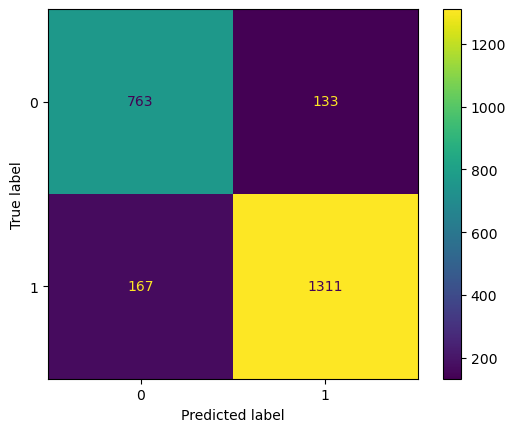

In [76]:
# Get predictions on the testing set
cb2_gs_yhat = cb2_gs.predict(X_test)

# Generate confusion matrix values
cm = confusion_matrix(y_test, cb2_gs_yhat)

# Save confusion matrix values
tn, fp, fn, tp = cm.ravel()

# Generate confusion matrix
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cb2_gs.classes_)
print('''Confusion Matrix for Subreddit Classification
Modeled with Count Vectorizer, Multinomial Naive Bayes''')
cmd.plot();

### Commentary

Although both models do provide modest improvements in accuracy, they also increase variance.  The logistic regression increases variance from tiny decimals to a full 4 points, and this Bayes model had a difference of >0.01 between training and testing, whereas the previous model had <0.0006.  It is perhaps not surprising that Bayes consistently outperformed logistic regression, given the stricter assumptions of logistic regression that are all but surely not met with text data like this.  While other scholars might justifiably prioritize the accuracy, I deem that my purposes are better served by reducing variance.  Future work, perhaps in collaboration with qualitative researchers, will benefit greatly from analyzing the misclassified posts, so I am less concerned with minimizing them than I am in producing the model that is most likely to be picking up on genuine differences in communication norms and least likely to be specializing itself to the training data.

I adopt the following model:

|Parameter|Value|
|-|-|
|Estimator|Multinomial Naive Bayes|
|Maximum features|1000|
|Maximum document frequency| 75%|
|Minimum document frequency| n=2|
|Ngram range| (1, 1) |
|Stop words| None|
|Smoothing alpha|0.9|
---

Confusion Matrix, Counts
[[ 699  197]
 [ 174 1304]]
Confusion Matrix, Normalized
[[0.78013393 0.21986607]
 [0.11772666 0.88227334]]


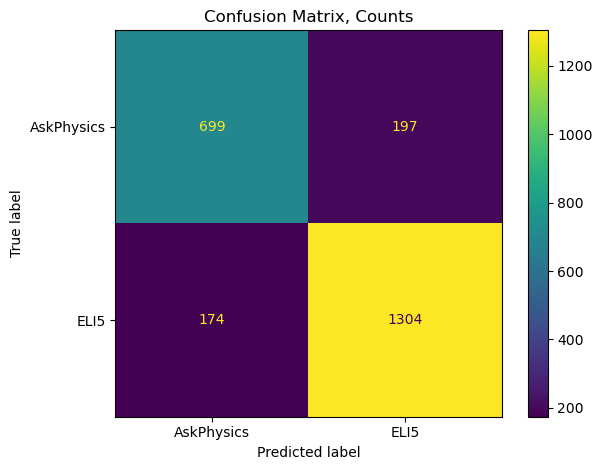

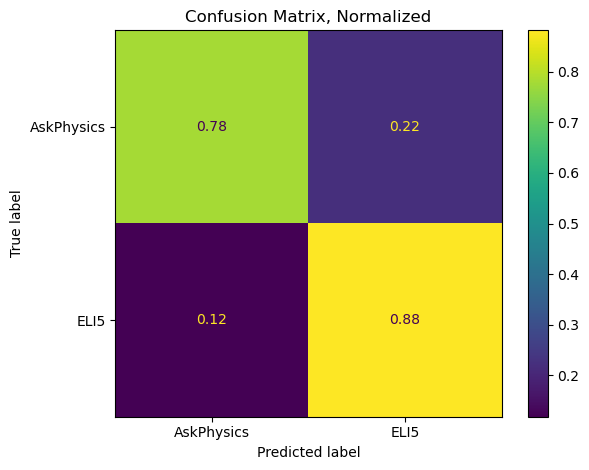

In [45]:
# Plotting nicer confusion matrices for the adopted model

# Many, many thanks to the good people at sklearn for providing this example syntax
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix
#               .html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
# And to Marta Fuentes and Dave Kanevsky for bringing it to my attention

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion Matrix, Counts", None),
    ("Confusion Matrix, Normalized", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, yhat_model,
        display_labels=['AskPhysics', 'ELI5'],
        cmap=plt.cm.viridis,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    plt.tight_layout()
    plt.savefig(f"../images/graphs/{title.replace(',', '').replace(' ', '_')}.png")

    print(title)
    print(disp.confusion_matrix);

plt.show();

## Conclusions and Recommendations

I successfully built a model that can differentiate between documents from the two subreddits up to my criteria for success: an accuracy score of >80% on the testing set (84.37%), and minimal variance (<0.0006).  Although other hyperparameter combinations offered modest increases to accuracy, I chose to minimize variance in order to maximize generalizability to the subreddits as a whole.  

By showing that this can be done, I have provided support for my proposition that these two subreddits could serve as useful model representations of scientific communication.  If the model can reliably tell the difference between them based on the text of their content, it implies that their members are using different communication strategies within that text.  That the model cannot always tell the difference provides fertile ground for further exploration into what key characteristics define each type of communication.

Therefore, I recommend further research on the communication norms of these two subreddits, as a promising source of insight on how to improve scientific communication.  Personally, I look forward to opportunities to test more stop words, compare the results of `Countvectorizer()` with those of `TfIdf()`, and incorporate additional data into the model.  In particular, I would be interested to explore the effects of including second-level comments, especially in conjunction with the marker indicating when a comment comes from the author of the original post.  Wherever this marker is present in a second-level comment, I would be interested to attempt sentiment analysis to gain insight on how the person who asked the question feels about the answer.  I would also be interested to evaluate other data related to the text, such as whether it is a post or a comment (both were included in the current model, but not differentiated), how many (sub-)comments it received, and its upvote/downvote score.  I believe all of these items could shed valuable further light onto the vexing but valuable pursuit of successful scientific communication.